In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [102]:
# Load the dataset
data = pd.read_csv("../data/fixed_data.csv")  
original_data = pd.read_csv('../data/Student data.csv',skiprows=24, header=None)

In [103]:
# Convert data to DataFrame
original_data = pd.DataFrame(original_data)
columns = ['firstTermGpa', 'secondTermGpa', 'firstLanguage', 'funding', 'school', 'fastTrack', 'coop', 'residency',
           'gender', 'previousEducation', 'ageGroup', 'highSchoolAverageMark', 'mathScore', 'englishScore', 'firstYearPersistence']
original_data.columns = columns

In [104]:
# Replace '?' with NaN
original_data.replace('?', np.nan, inplace=True)

In [105]:
numeric_features = ['firstTermGpa', 'secondTermGpa', 'highSchoolAverageMark', 'mathScore',]

# Create preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ]
)
original_data = preprocessor.fit_transform(original_data)

In [106]:
# Feature Engineering: Calculate GPA improvement (proxy for target)
data['gpaImprovement'] = original_data[:, 1].astype(float) - original_data[:, 0].astype(float)

In [107]:
# Estimate third semester GPA as Second Term GPA + Improvement Trend (or synthetic target)
data['Predicted_Third_Semester_GPA'] = original_data[:, 1] + data['gpaImprovement']
data['Predicted_Third_Semester_GPA'] 

0       0.000000
1       1.500000
2       3.596154
3       1.622025
4       4.378846
          ...   
1432   -1.413043
1433    3.788148
1434    2.879167
1435    4.692547
1436    4.278431
Name: Predicted_Third_Semester_GPA, Length: 1437, dtype: float64

In [108]:
# Select features: you can choose more or remove based on your dataset
X = data.drop(['firstLanguage_1', 'firstLanguage_2', 'firstLanguage_3', 'funding_1',
       'funding_2', 'funding_4', 'funding_5', 'funding_8', 'funding_9',
       'school_6', 'fastTrack_1', 'fastTrack_2', 'coop_1', 'coop_2',
       'residency_1', 'residency_2', 'gender_1', 'gender_2', 'gender_3',
       'previousEducation_0', 'previousEducation_1', 'previousEducation_2',
       'ageGroup_1', 'ageGroup_2', 'ageGroup_3', 'ageGroup_4', 'ageGroup_5',
       'ageGroup_6', 'ageGroup_7', 'ageGroup_8', 'englishScore_1',
       'englishScore_10', 'englishScore_2', 'englishScore_3', 'englishScore_4',
       'englishScore_7', 'englishScore_8', 'englishScore_9','gpaImprovement',
       'Predicted_Third_Semester_GPA'],axis=1)
y = data['Predicted_Third_Semester_GPA']

In [109]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [110]:
# Standardize the features (important for neural networks)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [111]:
# Define the neural network model
model = Sequential()

# Add input layer with 4 features (based on the selected features)
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.1))
# Add hidden layers
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(4, activation='relu'))

# Output layer (predicting continuous third semester GPA)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

d:\fall2024\neural network\project\code\scripts\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [112]:
best_model_filepath = "../models/gpa_prediction_model.keras"

# ModelCheckpoint callback
modelCheckpoint = ModelCheckpoint(
    filepath=best_model_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='max',
    verbose=1)
#EarlyStopping callback
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True,

)


In [113]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205 (820.00 B)

 Trainable params: 205 (820.00 B)

 Non-trainable params: 0 (0.00 B)

In [114]:
# Train the model
history = model.fit(
    X_train,
    y_train, 
    epochs=100, 
    batch_size=10, 
    validation_split=0.2,
    callbacks=[modelCheckpoint,earlyStopping],
    verbose=1)


Epoch 1/100


67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2327
Epoch 1: val_loss improved from -inf to 9.09904, saving model to ../models/gpa_prediction_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.9780 - val_loss: 9.0990
Epoch 2/100
63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1500 
Epoch 2: val_loss did not improve from 9.09904
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9633 - val_loss: 5.6780
Epoch 3/100
70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4887
Epoch 3: val_loss did not improve from 9.09904
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2463 - val_loss: 2.1030
Epoch 4/100
66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1946
Epoch 4: val_loss did not improve from 9.09904
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1033 - val_loss: 1.1224
Epoch 5/100
74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4707
Epoch 5: val_loss did not improve from 9.09904
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4497 - val_loss: 0.6653
Epoch 6/100
79/92 ━━━━━━

In [115]:
# Predict on the test set
y_pred = model.predict(X_test)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [116]:

# Evaluate the model: Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.031139960043059627


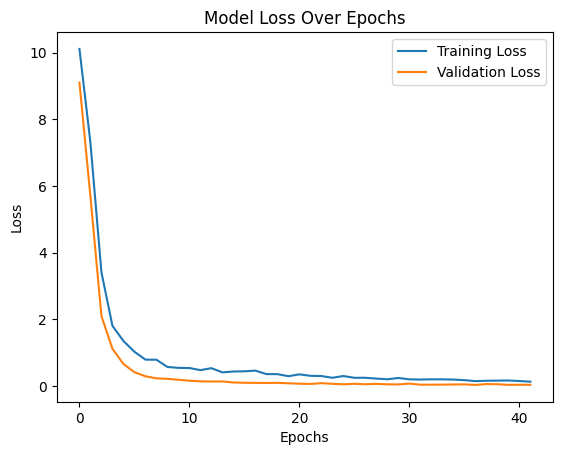

In [117]:
# Visualize the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

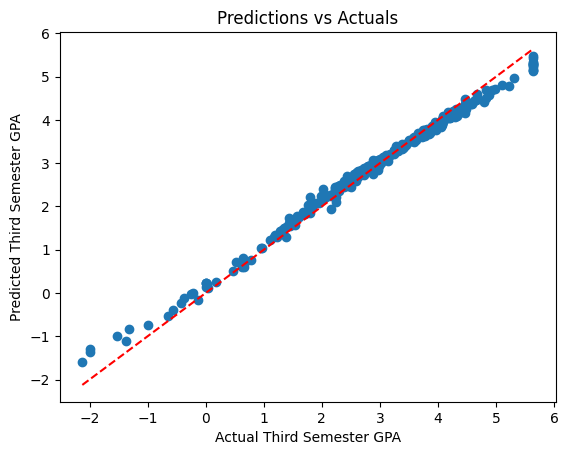

In [118]:
# Visualize predictions vs actual
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.xlabel("Actual Third Semester GPA")
plt.ylabel("Predicted Third Semester GPA")
plt.title("Predictions vs Actuals")
plt.show()